## Importing the  Modules to be used


In [4]:
import pandas as pd #DataFrame module
import numpy as np

import os #For file operations
import matplotlib.pyplot as plt # Data Visualization
import seaborn as sns # Data visualization
import warnings 
from tqdm.notebook import tqdm # For a progress bar
warnings.filterwarnings('ignore')
%matplotlib inline

import tensorflow as tf # ML Module
# Importing neural networking capabilities
from keras.preprocessing.image import load_img #For loading image into a numpy array
from keras.models import Sequential, Model # For a simple sequential model
# For adding different layers to the model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input 

## Loading the Dataset into the code

In [5]:
#File path of the dataset from Kaggle
BASE = '../input/utkface-new/UTKFace'


## Creating Lists to store data from filenames

In [6]:
#Labels: Age, Gender
image_paths=[]
age_labels=[]
gender_labels=[]
# Iteration over all the files in BASE directory
for filename in tqdm(os.listdir(BASE)):
    image_path=os.path.join(BASE, filename)
    # Splitting filename to get data
    temp=filename.split('_')
    age=int(temp[0])
    gender=int(temp[1])
    image_paths.append(image_path)
    age_labels.append(age)
    gender_labels.append(gender)

  0%|          | 0/23708 [00:00<?, ?it/s]

## Converting extracted data into a PANDAS data frame

In [7]:
df=pd.DataFrame()
df['image'],df['age'],df['gender']= image_paths, age_labels, gender_labels
df.head()

,image,age,gender
0,../input/utkface-new/UTKFace/26_0_2_2017010402...,26,0
1,../input/utkface-new/UTKFace/22_1_1_2017011223...,22,1
2,../input/utkface-new/UTKFace/21_1_3_2017010500...,21,1
3,../input/utkface-new/UTKFace/28_0_0_2017011718...,28,0
4,../input/utkface-new/UTKFace/17_1_4_2017010322...,17,1


In [8]:
#Mapping label for gender, taking binary genders where 0 is male and 1 is female
gender_map={0:'Male',1:'Female'}

## Exploratory Analysis of Data

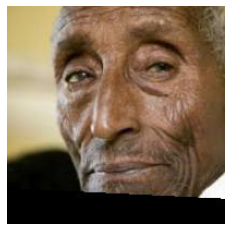

In [9]:
from PIL import Image 
import random #For random number generation
img=Image.open(df['image'][random.randint(0,23707)])
plt.axis('off') #Removes axis
plt.imshow(img)


<AxesSubplot:xlabel='age', ylabel='Density'>

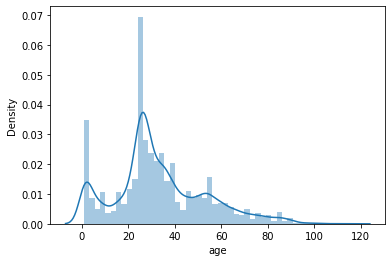

In [10]:
#Distribution of ages
sns.distplot(df['age'])

<AxesSubplot:xlabel='gender', ylabel='count'>

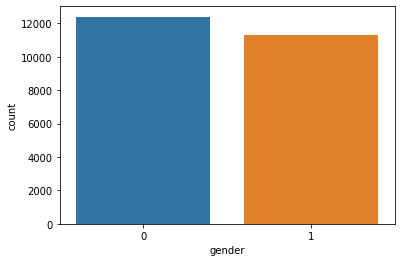

In [11]:
#Class distribution of genders
sns.countplot(df['gender'])

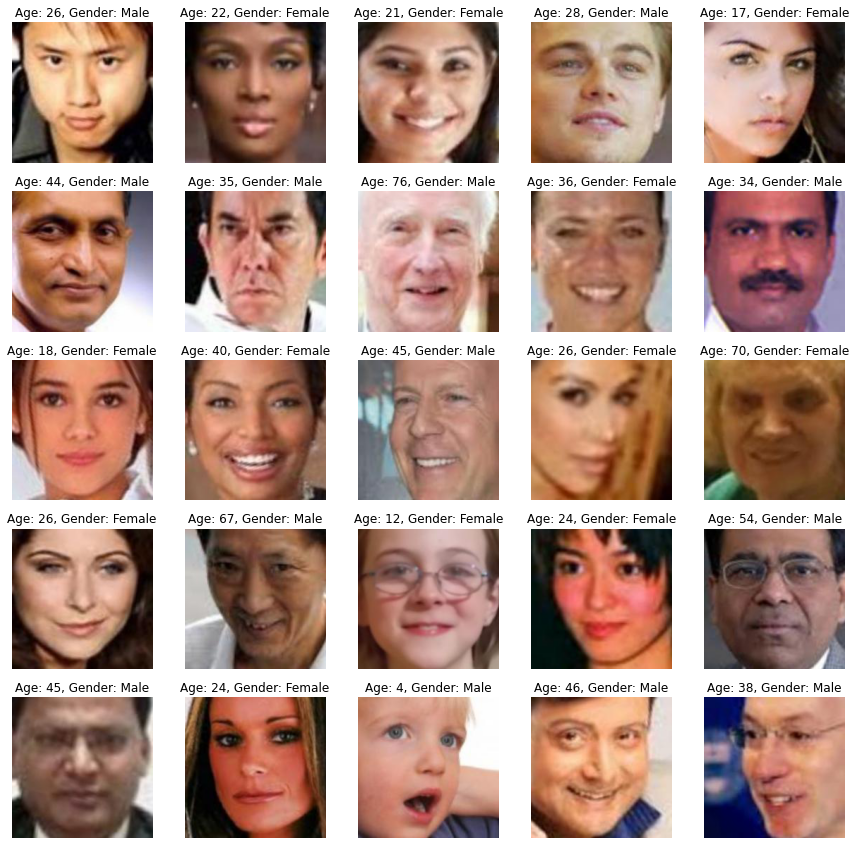

In [12]:
# Displaying few images for exploratory analysis
plt.figure(figsize=(15,15)) #Size of the images
files = df.iloc[0:25] #Selecting the first 25 images from the data frame
for index, file, age, gender in files.itertuples(): #Iteration through each tuple
           plt.subplot(5,5,index+1) #Since the index should start from 1 adding 1
           img=load_img(file) 
           img=np.array(img) #Loading each file as a numpy array  
           plt.imshow(img)
           plt.title("Age: {}, Gender: {}".format(age,gender_map[gender]))
           plt.axis('off')

### **Feature Extraction**: Converting images to grayscale and resizing to reduce dimensionality

In [13]:
def extract(images):
    features=[]
    for image in tqdm(images): #Taking each image
        #Converting each image to grayscale for standardization
        img=load_img(image, grayscale=True)
        img= img.resize((128,128), Image.ANTIALIAS)
        img=np.array(img)
        features+=[img]
    features=np.array(features)
    features=features.reshape(len(features),128,128,1)#Since we use grayscale images
    return features

In [14]:
X= extract(df['image'])


  0%|          | 0/23708 [00:00<?, ?it/s]

In [15]:
X.shape

(23708, 128, 128, 1)

In [16]:
## Normalize pixel values to be between 0 and 1
X=X/255.0 

In [17]:
#Converting gender into a numpy array
y_gender = np.array(df['gender']) 
y_age=np.array(df['age']) 

In [18]:
input_shape=(128,128,1)

## Creating the CNN Model

In [24]:
inputs=Input(input_shape)
# Convolutional Layers for feature learning
conv_1 = Conv2D(32,kernel_size=(3,3), activation='relu')(inputs)
maxp_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(64,kernel_size=(3,3), activation='relu')(maxp_1)
maxp_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(128,kernel_size=(3,3), activation='relu')(maxp_2)
maxp_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(256,kernel_size=(3,3), activation='relu')(maxp_3)
maxp_4 = MaxPooling2D(pool_size=(2,2))(conv_4)
# Relu activation is used since it best improves the model performance

# Convolutional layers have weights in a matrix like structure
# The flatten function can be used to convert them into 1D vectors
flatten=Flatten() (maxp_4)

#Fully connected layers (dense layers)

# Inserting the flattened features into the fully connected netwoek
dense_1= Dense(256, activation='relu')(flatten)
dense_2= Dense(256, activation='relu')(flatten)

dropout_1=Dropout(0.3)(dense_1)
dropout_2=Dropout(0.3)(dense_2)

output_1=Dense(1, activation='sigmoid', name='gender_out') (dropout_1)
output_2=Dense(1, activation='relu', name='age_out') (dropout_2)

model=Model(inputs=[inputs],outputs=[output_1,output_2])
model.compile(loss=['binary_crossentropy','mae'], optimizer='adam', metrics=['accuracy'])



## Plottting the model

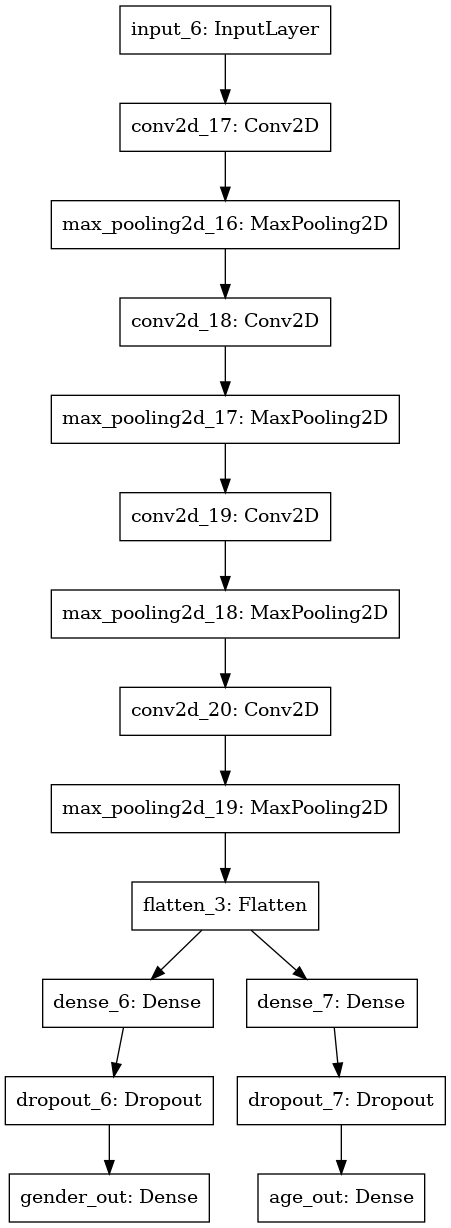

In [26]:
from tensorflow.keras.utils import plot_model
plot_model(model)


## Training the model

In [27]:
history= model.fit(x=X,y=[y_gender,y_age], batch_size=32, epochs=30, validation_split=0.2)

2022-09-24 03:38:30.261268: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1242955776 exceeds 10% of free system memory.
2022-09-24 03:38:31.641785: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 1242955776 exceeds 10% of free system memory.
2022-09-24 03:38:32.762580: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30


2022-09-24 03:38:34.568059: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


593/593 [==============================] - 17s 15ms/step - loss: 15.9860 - gender_out_loss: 0.6984 - age_out_loss: 15.2876 - gender_out_accuracy: 0.5302 - age_out_accuracy: 0.0476 - val_loss: 14.0560 - val_gender_out_loss: 0.6061 - val_age_out_loss: 13.4499 - val_gender_out_accuracy: 0.6818 - val_age_out_accuracy: 0.0462
Epoch 2/30
593/593 [==============================] - 8s 14ms/step - loss: 11.9331 - gender_out_loss: 0.5117 - age_out_loss: 11.4214 - gender_out_accuracy: 0.7518 - age_out_accuracy: 0.0400 - val_loss: 9.8970 - val_gender_out_loss: 0.4601 - val_age_out_loss: 9.4369 - val_gender_out_accuracy: 0.7714 - val_age_out_accuracy: 0.0179
Epoch 3/30
593/593 [==============================] - 8s 13ms/step - loss: 9.8217 - gender_out_loss: 0.4242 - age_out_loss: 9.3975 - gender_out_accuracy: 0.8030 - age_out_accuracy: 0.0255 - val_loss: 9.5675 - val_gender_out_loss: 0.3805 - val_age_out_loss: 9.1871 - val_gender_out_accuracy: 0.8197 - val_age_out_accuracy: 0.0236
Epoch 4/30
593/59

## Plot results for gender

<Figure size 432x288 with 0 Axes>

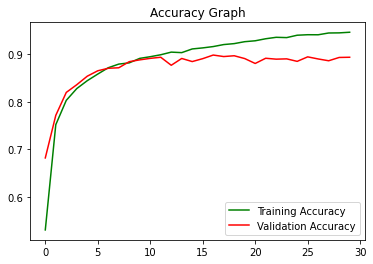

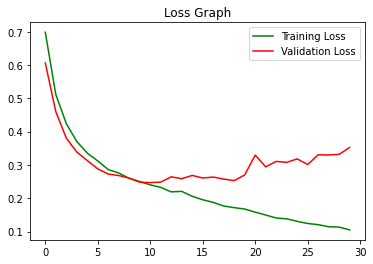

<Figure size 432x288 with 0 Axes>

In [35]:
#Plotting Accuracy
acc= history.history['gender_out_accuracy']
val_acc=history.history['val_gender_out_accuracy']
epochs= range(len(acc))
plt.plot(epochs, acc, 'g', label='Training Accuracy')
plt.plot(epochs,val_acc,'r',label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

#Plotting Loss
loss= history.history['gender_out_loss']
val_loss=history.history['val_gender_out_loss']
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

## Plotting results for age


<Figure size 432x288 with 0 Axes>

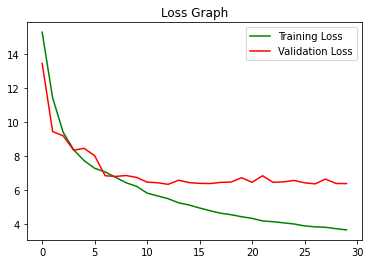

<Figure size 432x288 with 0 Axes>

In [36]:
loss= history.history['age_out_loss']
val_loss=history.history['val_age_out_loss']
epochs= range(len(acc))
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs,val_loss,'r',label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.figure()

## Prediction with Test Data 

Actual Gender: Female Actual Age: 20
Predicted Gender: Female Predicted Age: 22


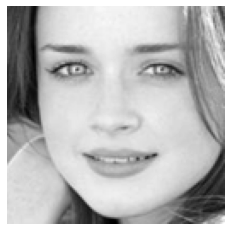

In [100]:
import random
image_index=random.randint(0,23707)
print('Actual Gender:',gender_map[y_gender[image_index]],"Actual Age:",y_age[image_index])
#Predict from model
pred=model.predict(X[image_index].reshape(1,128,128,1))
pred_gender=gender_map[round(pred[0][0][0])]
pred_age=round(pred[1][0][0])
print("Predicted Gender:", pred_gender,"Predicted Age:",pred_age)
plt.axis('off')
plt.imshow(X[image_index].reshape(128,128),cmap='gray')